<a href="https://colab.research.google.com/github/project-ida/arpa-e-experiments/blob/main/tutorials/neutron-detectors-efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;<a href="https://nbviewer.org/github/project-ida/arpa-e-experiments/blob/main/tutorials/neutron-detectors-efficiency.ipynb" target="_parent"><img src="https://nbviewer.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Neutron detectors efficiency

This tutorial involves analyzing the effects of a steel chamber on neutron detection by placing a neutron source in a graphite tunnel both inside and outside the chamber.

In [2]:
# Makes Libs accessible and runs notebook from same location regardless of whether colab or local
!pip install colocal --upgrade -q
import colocal
root, branch, cwd = colocal.setup()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.3 MB/s eta 0:00:00
[Colab] Repo: arpa-e-experiments | Branch: main
[Colab] Repo root added to sys.path
[Colab] Working directory set to: tutorials


In [3]:
# Libraries and helper functions

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import Image, display, Video, HTML

from scipy.signal import find_peaks
from scipy.stats import ttest_ind
from datetime import datetime


# Use our custom helper functions
# - process_data
# - plot_panels
# - plot_panels_with_scatter
# - print_info
from libs.helpers import *

## Setup 1: Neutron source **outside** the steel chamber in a graphite tunnel
The neutron source is placed in the graphite tunnel.

<img src="https://drive.google.com/uc?id=1DKYgSHlc5DhPCJWa6kxlR79Mp6qzZgKx" width="500">


## Setup 2: Neutron source **inside** the steel chamber in a graphite tunnel
In this setup, the neutron source is placed in the steel chamber, within the graphite tunnel.This setup aims to analyze how the steel chamber affects neutron detection.

<img src="https://drive.google.com/uc?export=download&id=1-Otyr-5PNUflYPbPSqNvbSKBgJFyDPpo" width="500">




# Reading the Raw Data


## Counts per minute above 50 threshold



In [ ]:
# Read the counts per minute data
CountsPerMinute = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-steeltest2-19.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

In [ ]:
# Print out basic description of the data, including any NaNs
print_info(CountsPerMinute)

Measurements start at: 2024-12-08 18:30:14
Measurements end at: 2024-12-10 20:59:54
---------
Total number of measurements: 2792
Time between measurements: 65.107449 s
---------
Total number of NaNs
Counts ch200-1000    0
Counts ch60-1000     0
Counts ch50-1000     0
dtype: int64


We are only interested in the counts above the 50 thrshold so we will drop the data with higher thresholds. Since we'll only be interested in `ch50-1000`, we'll rename it to make plotting a bit easier later.

In [ ]:
CountsPerMinute.rename(columns={'Counts ch50-1000': 'Counts Per Minute (CPM)'}, inplace=True)

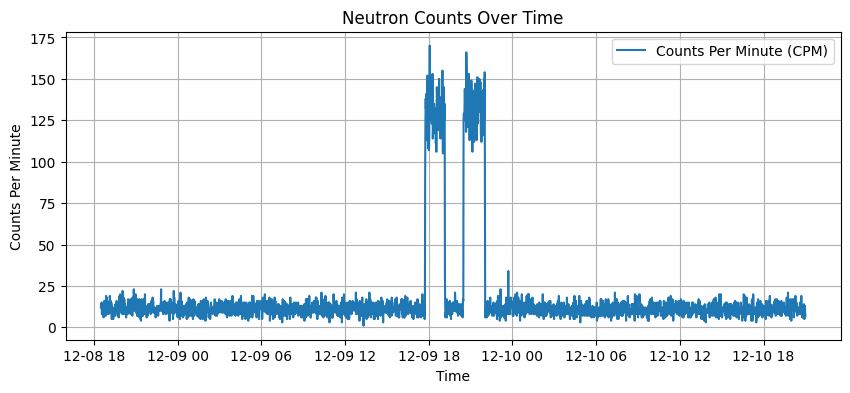

In [ ]:
# Plot the neutron counts over time
plt.figure(figsize=(10, 4))
plt.plot(CountsPerMinute.index, CountsPerMinute['Counts Per Minute (CPM)'], label='Counts Per Minute (CPM)', marker='', linestyle='-')
plt.title('Neutron Counts Over Time')
plt.xlabel('Time')
plt.ylabel('Counts Per Minute')
plt.legend()
plt.grid(True)
plt.show()

## Comparing the Peaks

Tunnel Data Range: Start=1289, End=1369
Chamber Data Range: Start=1441, End=1529


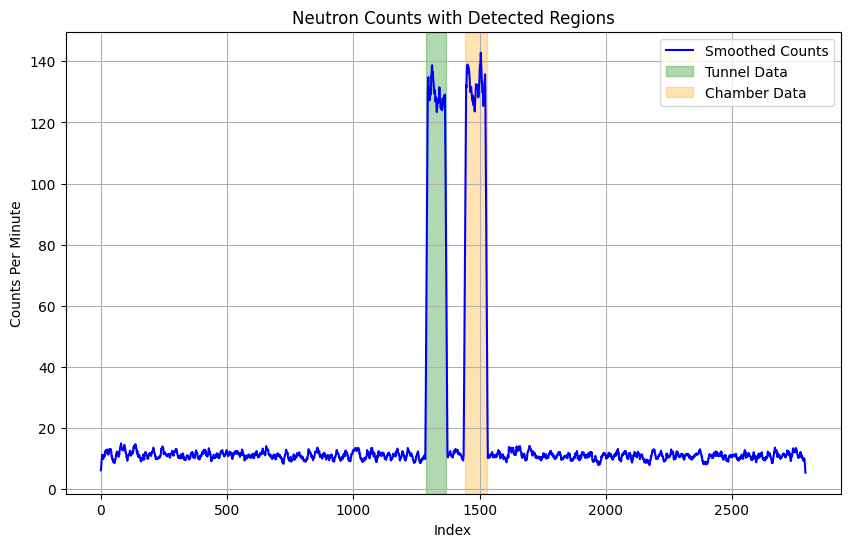

In [ ]:
# Extract the counts column
counts = CountsPerMinute['Counts Per Minute (CPM)'].values

# Smooth the data using a rolling mean (optional, to reduce noise)
window_size = 10  # Adjust window size as needed
smoothed_counts = np.convolve(counts, np.ones(window_size) / window_size, mode='same')

# Detect edges (start and end of peaks)
threshold = 50  # Adjust based on your data
edges = np.where(smoothed_counts > threshold)[0]

# Ensure edges are well-defined and identify ranges
if len(edges) > 0:
    # Split the detected edges into two distinct ranges
    mid_point = (edges[-1] - edges[0]) // 2 + edges[0]  # Midpoint between first and last edge
    tunnel_edges = edges[edges <= mid_point]  # First range for tunnel
    chamber_edges = edges[edges > mid_point]  # Second range for chamber

    if len(tunnel_edges) > 0 and len(chamber_edges) > 0:
        tunnel_range = (tunnel_edges[0], tunnel_edges[-1])
        chamber_range = (chamber_edges[0], chamber_edges[-1])

        tunnel_data = counts[tunnel_range[0]:tunnel_range[1]]
        chamber_data = counts[chamber_range[0]:chamber_range[1]]

        print(f"Tunnel Data Range: Start={tunnel_range[0]}, End={tunnel_range[1]}")
        print(f"Chamber Data Range: Start={chamber_range[0]}, End={chamber_range[1]}")

        # Plot the signal with detected regions
        plt.figure(figsize=(10, 6))
        plt.plot(smoothed_counts, label='Smoothed Counts', linestyle='-', color='blue')
        plt.axvspan(tunnel_range[0], tunnel_range[1], color='green', alpha=0.3, label='Tunnel Data')
        plt.axvspan(chamber_range[0], chamber_range[1], color='orange', alpha=0.3, label='Chamber Data')
        plt.title('Neutron Counts with Detected Regions')
        plt.xlabel('Index')
        plt.ylabel('Counts Per Minute')
        plt.legend()
        plt.grid(True)
        plt.show()

    else:
        print("Failed to define clear tunnel or chamber ranges. Check edge detection logic.")
else:
    print("No significant edges found!")

## Peak Statistics

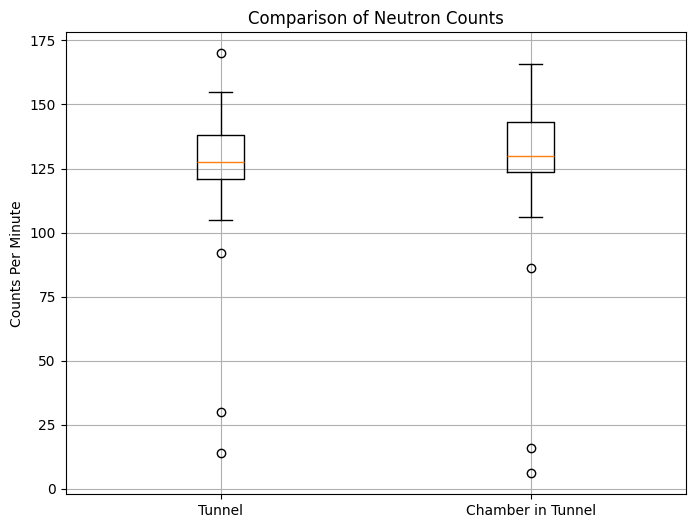

In [ ]:
plt.figure(figsize=(8, 6))
plt.boxplot([tunnel_data, chamber_data], labels=['Tunnel', 'Chamber in Tunnel'])
plt.title('Comparison of Neutron Counts')
plt.ylabel('Counts Per Minute')
plt.grid(True)
plt.show()

We notice a few outliers that may disrupt our data so we will filter them out:

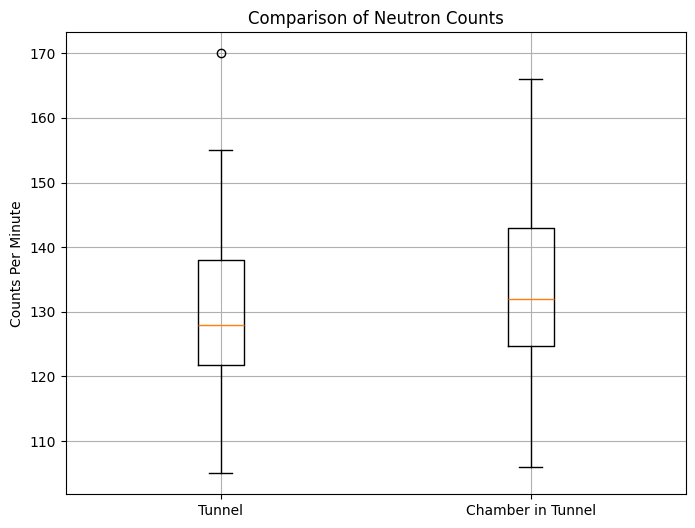

In [ ]:
'''

def remove_outliers(data, threshold=1):
    # Compute mean and standard deviation
    mean = np.mean(data)
    std = np.std(data)
    z_scores = (data - mean) / std
    filtered_data = data[np.abs(z_scores) <= threshold]
    return filtered_data

filtered_tunnel_data = remove_outliers(tunnel_data)
filtered_chamber_data = remove_outliers(chamber_data)
'''

def remove_ramp(data):
  return data[2:-2]

filtered_tunnel_data = remove_ramp(tunnel_data)
filtered_chamber_data = remove_ramp(chamber_data)

plt.figure(figsize=(8, 6))
plt.boxplot([filtered_tunnel_data, filtered_chamber_data], labels=['Tunnel', 'Chamber in Tunnel'])
plt.title('Comparison of Neutron Counts')
plt.ylabel('Counts Per Minute')
plt.grid(True)
plt.show()

In [ ]:
def compute_statistics(data, label):
  stats = {'Mean': np.mean(data),
            'Standard Deviation': np.std(data),
            'Median': np.median(data),
            'Variance': np.var(data),
            'Minimum': np.min(data),
            'Maximum': np.max(data),
            'Count': len(data)
        }
  print(f"\n{label} Statistics:")
  for key, value in stats.items():
      print(f"{key}: {value:.2f}")
  return stats
# Compute statistics for tunnel and chamber data

tunnel_stats = compute_statistics(filtered_tunnel_data, 'Tunnel Data')
chamber_stats = compute_statistics(filtered_chamber_data, 'Chamber Data')


Tunnel Data Statistics:
Mean: 129.32
Standard Deviation: 12.35
Median: 128.00
Variance: 152.48
Minimum: 105.00
Maximum: 170.00
Count: 76.00

Chamber Data Statistics:
Mean: 132.31
Standard Deviation: 11.90
Median: 132.00
Variance: 141.55
Minimum: 106.00
Maximum: 166.00
Count: 84.00


Let us now examine whether the difference between the two peaks is more significant that the standard deviation. We can start by doing a T-test

In [ ]:
t_stat, p_value = ttest_ind(filtered_tunnel_data, filtered_chamber_data, equal_var=False)  # Use Welch's t-test if variances are unequal
print("\nT-Test Results:")
print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")


T-Test Results:
T-statistic: -1.548345606173446
P-value: 0.12357810661413594


The standard significance level set in a t-test is 5%. We see here that our P-Value ~ 12.35% is above below the significance level. Hence, the means of the tunnel and chamber data are not significantly different.

# Estimating our Detector Efficiency

We know that our source strength was 17.3 nCi on September 4th 2024. This measurement was taken on December 8th 2024, starting at 18:30:14.

Given the half-life of our source, Cf-252, which is 2.647 years, we can estimate what our source strength was the day of the experiment: 16.16094 nCi.

Furthermore, we know that 1 µCi = 3.7×10^4 disintegrations per second = 2.22×10^6 disintegrations per minute (dpm). Hence 1nCi = 37 dps = 2.22*10^3 dpm

Finally, "252Cf disintegrates by α emissions mainly to the 248Cm ground state level, and by spontaneous fission for 3,086%" (https://inis.iaea.org/search/search.aspx?orig_q=RN%3A45014763&utm)

In [ ]:
A0 = 17.3 # Initial activity in nCi
half_life = 2.647  # in years
decay_constant = np.log(2) / half_life
spontaneous_fission_fraction = 0.03086  # Fraction of disintegrations resulting in fission
neutrons_per_fission = 3.7573   # Average neutrons emitted per fission (± 0.0056)
conversion_factor = 37  # Conversion factor from nCi to dps (disintegrations per second)

date_initial = datetime(2024, 9, 4)  # activity meansurment taken September 4, 2024
date_experiment = datetime(2024, 12, 8)  # Experiment date: December 8, 2024
time_difference = (date_experiment - date_initial).days / 365.25

At = A0 * np.exp(-decay_constant * time_difference) # Activity on the day of the experiment
dps_t = At*conversion_factor
neutrons_ps_t = dps_t * spontaneous_fission_fraction

In [ ]:
neutrons_pm_t = neutrons_ps_t * 60
# Experiment-specific data
neutrons_detected_per_minute =  np.mean(filtered_tunnel_data) # Total counts detected during the experiment

# Setup efficiency
detector_efficiency = neutrons_detected_per_minute /neutrons_pm_t

# Results
print(f"Expected neutron emissions per minute: {neutrons_pm_t:.2f} neutrons per second")
print(f"Measured neutrons per minute: {neutrons_detected_per_minute:.2f} neutrons")
print(f"Detector efficiency: {detector_efficiency:.6f} ({detector_efficiency * 100:.2f}%)")

Expected neutron emissions per minute: 1107.17 neutrons per second
Measured neutrons per minute: 129.32 neutrons
Detector efficiency: 0.116798 (11.68%)


In this computation, we assumed that our detectors communaly cover the sample's entire solid angle. In reality, this is not true as the gaps between each tube causes gaps in the solid angle. Hence, this efficiency, of 11.68% corresponds to the efficiency of our setup as a whole rather than that of each liquid scintillation detector.

# Comparing the Neutron Tubes

Let us now have a look at each individual tube to compare their count rates.

In [ ]:
# Read the counts per minute data for each channel 0 - 7

CountsPerMinute_0 = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-steeltest2-1.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

CountsPerMinute_1 = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-steeltest2-3.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

CountsPerMinute_2 = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-steeltest2-5.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

CountsPerMinute_3 = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-steeltest2-7.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

CountsPerMinute_4 = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-steeltest2-9.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

CountsPerMinute_5 = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-steeltest2-11.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

CountsPerMinute_6 = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-steeltest2-13.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

CountsPerMinute_7 = pd.read_csv(
    'http://nucleonics.mit.edu/csv-files/he3-detectors-steeltest2-15.csv',
    parse_dates=['time'],
    date_format="ISO8601",
    index_col='time'
)

In [ ]:
means = np.array([CountsPerMinute_0.mean(), CountsPerMinute_1.mean(), CountsPerMinute_2.mean(), CountsPerMinute_3.mean(),
         CountsPerMinute_4.mean(), CountsPerMinute_6.mean(), CountsPerMinute_7.mean()])

worst_efficiency = np.where(means == means.min())

means

array([[0.03770137],
       [0.03831042],
       [0.0364773 ],
       [0.03644148],
       [0.04043613],
       [0.03899113],
       [0.03569509]])